# 1.Huấn luyện dữ liệu và lưu thành checkpoint

docs lib: https://keras.io/api/layers/recurrent_layers/lstm/

In [1]:
#@title Nhập tên các bộ dữ liệu huấn luyện, và tỷ lệ dữ liệu để huấn luyện, còn lại là validate
L_source = ",".join(map(lambda x: f"/cic/dataset/normalized_labeled/{x}/", [
    'nsm-2023w11-08-label',
    'nsm-2023w11-07-label',
    'nsm-2023w11-06-label',
    #'nsm-2023w09-04-label',
    #'nsm-2023w09-02-label',
    #'nsm-2023w09-01-label',
    #'nsm-2023w06-ssh-02-label',
    #'nsm-2023w07-dos-02-label',
    #'nsm-2023w07-01-label',
]))
# nếu data visualization không hiển thị phần dữ liệu validation thì hạ tỷ lệ train_size_ratio xuống
# đặt để data visualization hiển thị dữ liệu anomaly trên cả 2 tập: train và test
train_size_ratio = 0.7

In [2]:
#@title Nhập tên checkpoint để lưu trữ, trùng với tên file huấn luyện AI Agent testing
checkpoint = '2023W1108'

# 2.PREPARATION

In [3]:
#@title Check version vs GPU
!git --version
!python --version
!ray --version

import tensorflow as tf
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)

import sys
sys.version

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

git version 2.20.1
Python 2.7.16
ray, version 1.13.0
tf version:  2.7.0
tf.keras version: 2.7.0
Found GPU at: /device:GPU:0


2023-03-18 15:37:37.349474: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-18 15:37:39.894713: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-03-18 15:37:39.895941: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 13348 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-03-18 15:37:39.897004: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capabilit

In [4]:
#@title Import Libraries
!mkdir -p /cic/images/

import sys
sys.path.insert(0, "/usr/local/opnsense/scripts/ml")

import json
import ray
import pyarrow
import pyarrow as pa
from pyarrow import csv
from pandas import DataFrame

from ray.data import Dataset
from ray.data.aggregate import Count

import numpy as np
from numpy import array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras import Input


import common
from anomaly_normalization import PS, LABEL, PAYLOAD_FEATURE_NUM, ALL_FEATURES
from aimodels.preprocessing.cicflowmeter_norm_model import CicFlowmeterNormModel
from aitests.testutils import show_scattered_4d, show_weights, show_4d_imgs, show_train_metric, IMG,\
read_csv_in_dir, read_csv_in_dir_label_string, evaluate_checkpoint_metric

run, client = common.init_experiment(name='notebook')
client.log_param(run_id=run.info.run_id, key='checkpoint', value=checkpoint)

2023-03-18 15:37:42,889[INFO][140620703651648-MainThread] worker.py:init(957) Connecting to existing Ray cluster at address: 172.18.12.180:6379
2023-03-18 15:37:43,977[INFO][140620703651648-MainThread] migration.py:__init__(204) Context impl PostgresqlImpl.
2023-03-18 15:37:43,978[INFO][140620703651648-MainThread] migration.py:__init__(211) Will assume transactional DDL.


# 3.INPUT
Let's generate a sample input with time dimension as below:

In [5]:
#@title Generate an input sequence

cell_size = 320 #@param {type:"integer"} #numberOfLSTMunits
hidden_size = 230 #@param {type:"integer"}
n_timesteps_in = 100  #@param {type:"integer"} # so 100 trong hinh 4d
n_features = 79   #@param {type:"integer"}

# dataset size la tong so flow trong L_source, lay tu cac file csv da duoc gan nhan va chuan hoa
# dataset size = (n_timesteps_in * train_size) + (n_timesteps_in * test_size) = train dataset size + test dataset size

# generate datasets
#train_size= 500 #@param {type:"integer"}    # la 413 trong hinh la kich thuoc bo du lieu dua vao huan luyen
#test_size = 123  #@param {type:"integer"}
batch_size=32 #@param {type:"integer"}
epochs=110 #@param {type:"integer"}

L_data: Dataset = read_csv_in_dir(L_source)
L_count: DataFrame = L_data.groupby(LABEL).aggregate(Count()).to_pandas()

features = ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pkt_len_max', 'pkt_len_mean', 'pkt_len_min', 'pkt_len_std', 'pkt_len_var', 'pkt_size_avg', 'protocol', 'psh_flag_cnt', 'rst_flag_cnt', 'src_port', 'subflow_bwd_byts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_fwd_pkts', 'syn_flag_cnt', 'tot_bwd_pkts', 'tot_fwd_pkts', 'totlen_bwd_pkts', 'totlen_fwd_pkts', 'urg_flag_cnt']
#features = [*features, *[PS % i for i in range(0, PAYLOAD_FEATURE_NUM)]]
features = features[0: n_features]
Lpadding_features = sorted(list(set(features) - set(L_data.schema(fetch_if_missing=True).names)))


total_size = int(L_count.sum()['count()']) // n_timesteps_in
train_size = int(total_size * train_size_ratio)
test_size = total_size - train_size
print ('features=', features)
print ('Lpadding_features=', Lpadding_features)
print ('total_size = ', total_size)
print ('train_size = ', train_size)
print ('test_size = ', test_size)

L_train = DataFrame.from_records(L_data.take(train_size * n_timesteps_in))
L_train[Lpadding_features] = 0
LX_train = L_train[features].to_numpy().reshape(train_size, n_timesteps_in, n_features)
Ly_train = L_train[[LABEL]].to_numpy().reshape((train_size, n_timesteps_in))

L_test = DataFrame.from_records(L_data.take(test_size * n_timesteps_in))
L_test[Lpadding_features] = 0
LX_test = L_test[features].to_numpy().reshape(test_size, n_timesteps_in, n_features)
Ly_test = L_test[[LABEL]].to_numpy().reshape(test_size, n_timesteps_in)

print ('done loading')

(_prepare_read pid=35175) 2023-03-18 15:37:45,543	WARNING file_meta_provider.py:161 -- Expanding 3 path(s). This may be a HIGH LATENCY operation on some cloud storage services. If the specified paths all point to files and never directories, try rerunning this read with `meta_provider=FastFileMetadataProvider()`.
Shuffle Reduce: 100%|██████████| 1/1 [00:00<00:00, 40.10it/s]


features= ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pk

In [6]:
L_count

,label,count()
0,0.0,99389
1,1.0,63471


## Data preview

### L_train preview

In [7]:
L_train[[LABEL, *features]]

,label,ack_flag_cnt,active_max,active_mean,active_min,active_std,bwd_blk_rate_avg,bwd_byts_b_avg,bwd_header_len,bwd_iat_max,bwd_iat_mean,bwd_iat_min,bwd_iat_std,bwd_iat_tot,bwd_pkt_len_max,bwd_pkt_len_mean,bwd_pkt_len_min,bwd_pkt_len_std,bwd_pkts_b_avg,bwd_pkts_s,bwd_psh_flags,bwd_seg_size_avg,bwd_urg_flags,cwe_flag_count,down_up_ratio,dst_port,ece_flag_cnt,fin_flag_cnt,flow_byts_s,flow_duration,flow_iat_max,flow_iat_mean,flow_iat_min,flow_iat_std,flow_pkts_s,fwd_act_data_pkts,fwd_blk_rate_avg,fwd_byts_b_avg,fwd_header_len,fwd_iat_max,fwd_iat_mean,fwd_iat_min,fwd_iat_std,fwd_iat_tot,fwd_pkt_len_max,fwd_pkt_len_mean,fwd_pkt_len_min,fwd_pkt_len_std,fwd_pkts_b_avg,fwd_pkts_s,fwd_psh_flags,fwd_seg_size_avg,fwd_seg_size_min,fwd_urg_flags,idle_max,idle_mean,idle_min,idle_std,init_bwd_win_byts,init_fwd_win_byts,pkt_len_max,pkt_len_mean,pkt_len_min,pkt_len_std,pkt_len_var,pkt_size_avg,protocol,psh_flag_cnt,rst_flag_cnt,src_port,subflow_bwd_byts,subflow_bwd_pkts,subflow_fwd_byts,subflow_fwd_pkts,syn_flag_cnt,tot_bwd_pkts,tot_fwd_pkts,totlen_bwd_pkts,totlen_fwd_pkts,urg_flag_cnt
0,0.0,1.000000,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.761594,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.999329,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.000000,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.999988,0.999998,0.000000,1.0,1.0,0.0,1.0,0.000000,0.964028,1.000000,1.000000,1.0,1.0,0.0
1,0.0,0.964028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.761594,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.999988,0.761594,0.000000,1.0,0.0,0.0,1.0,0.761594,0.000000,0.000000,0.964028,0.0,1.0,0.0
2,0.0,0.964028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.761594,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.999988,0.761594,0.000000,1.0,0.0,0.0,1.0,0.761594,0.000000,0.000000,0.964028,0.0,1.0,0.0
3,0.0,0.995055,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.964028,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.761594,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.999988,0.964028,0.000000,1.0,1.0,0.0,1.0,0.000000,0.000000,0.964028,0.761594,1.0,1.0,0.0
4,0.0,0.964028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.761594,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.999988,0.761594,0.000000,1.0,0.0,0.0,1.0,0.761594,0.000000,0.000000,0.964028,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113895,1.0,1.000000,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.000000,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.000000,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.999988,1.000000,0.000000,1.0,1.0,0.0,1.0,0.000000,0.964028,1.000000,1.000000,1.0,1.0,0.0
113896,1.0,1.000000,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.000000,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.000000,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1

In [8]:
L_train[[LABEL, *features]].describe()

,label,ack_flag_cnt,active_max,active_mean,active_min,active_std,bwd_blk_rate_avg,bwd_byts_b_avg,bwd_header_len,bwd_iat_max,bwd_iat_mean,bwd_iat_min,bwd_iat_std,bwd_iat_tot,bwd_pkt_len_max,bwd_pkt_len_mean,bwd_pkt_len_min,bwd_pkt_len_std,bwd_pkts_b_avg,bwd_pkts_s,bwd_psh_flags,bwd_seg_size_avg,bwd_urg_flags,cwe_flag_count,down_up_ratio,dst_port,ece_flag_cnt,fin_flag_cnt,flow_byts_s,flow_duration,flow_iat_max,flow_iat_mean,flow_iat_min,flow_iat_std,flow_pkts_s,fwd_act_data_pkts,fwd_blk_rate_avg,fwd_byts_b_avg,fwd_header_len,fwd_iat_max,fwd_iat_mean,fwd_iat_min,fwd_iat_std,fwd_iat_tot,fwd_pkt_len_max,fwd_pkt_len_mean,fwd_pkt_len_min,fwd_pkt_len_std,fwd_pkts_b_avg,fwd_pkts_s,fwd_psh_flags,fwd_seg_size_avg,fwd_seg_size_min,fwd_urg_flags,idle_max,idle_mean,idle_min,idle_std,init_bwd_win_byts,init_fwd_win_byts,pkt_len_max,pkt_len_mean,pkt_len_min,pkt_len_std,pkt_len_var,pkt_size_avg,protocol,psh_flag_cnt,rst_flag_cnt,src_port,subflow_bwd_byts,subflow_bwd_pkts,subflow_fwd_byts,subflow_fwd_pkts,syn_flag_cnt,tot_bwd_pkts,tot_fwd_pkts,totlen_bwd_pkts,totlen_fwd_pkts,urg_flag_cnt
count,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.0,113900.000000,113900.0,113900.000000,113900.000000,113900.0,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.0,113900.0,1.139000e+05,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.0,113900.000000,113900.000000,113900.000000,1.139000e+05,113900.0,113900.0,113900.0,113900.0,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.0,113900.000000,113900.0,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.000000,113900.0
mean,0.385882,0.909517,0.229025,0.229025,0.229024,0.158366,0.363705,0.364337,0.739939,0.650490,0.650490,0.638120,0.635126,0.650490,0.652336,0.652222,0.187936,0.554639,0.364317,0.447371,0.0,0.652222,0.0,0.002811,0.220562,1.0,0.002811,0.323630,0.729548,0.992683,0.994210,0.992682,0.839139,0.703481,0.773614,0.649525,0.0,0.0,1.000000e+00,0.922739,0.922686,0.910520,0.664985,0.922687,0.730175,0.728629,0.099281,0.642275,0.0,0.704935,0.176257,0.728629,1.000000e+00,0.0,1.0,1.0,1.0,0.265663,0.631528,0.900606,0.737882,0.735689,0.070931,0.735201,0.734070,0.736170,0.999989,0.641932,0.170931,1.0,0.652003,0.0,0.719340,0.198061,0.287418,0.717971,0.972128,0.652343,0.731112,0.0
std,0.486805,0.265032,0.420207,0.420207,0.420205,0.365060,0.481724,0.481246,0.438670,0.476798,0.476798,0.480282,0.481396,0.476798,0.476189,0.476215,0.390628,0.474613,0.481220,0.429256,0.0,0.476215,0.0,0.050470,0.352750,0.0,0.050470,0.378451,0.442371,0.119812,0.106394,0.119812,0.530880,0.456585,0.315621,0.468396,0.0,0.0,2.791566e-08,0.267385,0.267566,0.288011,0.471903,0.267567,0.441127,0.441690,0.296188,0.476540,0.0,0.366100,0.321202,0.441690,5.693051e-08,0.0,0.0,0.0,0.0,0.441687,0.482392,0.299192,0.438652,0.439559,0.256710,0.439708,0.440665,0.439329,0.000003,0.462315,0.326669,0.0,0.476276,0.0,0.448942,0.334088,0.443313,0.430843,0.062727,0.476192,0.441418,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.0,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.0,0.0,9.999998e-01,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,9.999998e-01,0.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.00000

In [9]:
DataFrame.from_records(LX_train[0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78
0,1.000000,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.000000,0.0,1.0,0.0,0.0,0.761594,1.0,0.0,0.761594,1.000000,1.0,1.0,1.0,0.0,1.0,1.000000,0.999329,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.000000,1.000000,0.0,1.000000,0.0,1.000000,0.000000,1.000000,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.999988,0.999998,0.000000,1.0,1.0,0.0,1.0,0.000000,0.964028,1.000000,1.000000,1.0,1.000000,0.0
1,0.964028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.761594,1.000000,1.0,1.0,1.0,1.0,0.0,1.000000,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.000000,1.000000,0.0,1.000000,0.0,1.000000,0.761594,1.000000,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.999988,0.761594,0.000000,1.0,0.0,0.0,1.0,0.761594,0.000000,0.000000,0.964028,0.0,1.000000,0.0
2,0.964028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.761594,1.000000,1.0,1.0,1.0,1.0,0.0,1.000000,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.000000,1.000000,0.0,1.000000,0.0,1.000000,0.761594,1.000000,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.999988,0.761594,0.000000,1.0,0.0,0.0,1.0,0.761594,0.000000,0.000000,0.964028,0.0,1.000000,0.0
3,0.995055,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.000000,0.0,1.0,0.0,0.0,0.964028,1.0,0.0,0.761594,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.0,0.000000,0.0,1.000000,0.761594,1.000000,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.999988,0.964028,0.000000,1.0,1.0,0.0,1.0,0.000000,0.000000,0.964028,0.761594,1.0,1.000000,0.0
4,0.964028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.761594,1.000000,1.0,1.0,1.0,1.0,0.0,1.000000,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.000000,1.000000,0.0,1.000000,0.0,1.000000,0.761594,1.000000,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.999988,0.761594,0.000000,1.0,0.0,0.0,1.0,0.761594,0.000000,0.000000,0.964028,0.0,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.964028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.761594,0.000000,1.0,1.0,1.0,1.0,0.0,0.616348,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.000000,0.000000,0.0,0.000000,0.0,0.616348,0.000000,0.000000,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.999988,0.000000,0.000000,1.0,0.0,0.0,0.0,0.761594,0.000000,0.000000,0.964028,0.0,0.000000,0.0
96,0.995055,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.056682,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.761594,0.056682,1.0,1.0,1.0,1.0,1.0,0.168602,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.761594,0.462117,0.0,0.608859,0.0,0.113000,0.000000,0.462117,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.761594,0.462117,0.0,0.520737,0.321513,0.582783,0.999988,0.000000,0.000000,1.0,0.0,0.0,0.0,0.000000,0.000000,0.761594,0.964028,0.0,0.761594,0.0
97,0.964028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.761594,0.000000,1.0,1.0,1.0,1.0,0.0,0.698241,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.000000,0.000000,0.0,0.000000,0.0,0.698241,0.000000,0.000000,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.000000,0

In [10]:
DataFrame.from_records(LX_train[0]).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78
count,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.000000,100.000000,100.0,100.000000,100.0,100.0,100.000000,100.0,100.0,1.000000e+02,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,100.00,100.000000,100.000000,100.0,100.0,100.0,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.000000,100.000000,100.0,100.0,100.0,100.0,100.0,100.00000,100.000000,100.0,100.000000,100.000000,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0
mean,0.979336,0.100000,0.100000,0.100000,0.0,0.140000,0.140000,0.370000,0.310000,0.310000,0.310000,0.280000,0.310000,0.310000,0.310000,0.0,0.310000,0.140000,0.269452,0.0,0.310000,0.0,0.0,0.262567,1.0,0.0,7.615942e-01,0.615107,1.000000e+00,1.000000e+00,1.000000e+00,0.909641,0.45,0.846987,0.162248,0.0,0.0,1.0,0.860000,0.860000,0.85000,0.230000,0.860000,0.599007,0.596012,0.111391,0.486089,0.0,0.806635,0.258942,0.596012,1.0,0.0,1.0,1.0,1.0,0.15000,0.360000,1.0,0.627616,0.624614,0.0,0.625207,0.623215,0.625827,0.999988,0.516307,0.007616,1.0,0.309998,0.0,0.500000,0.479804,0.134964,0.353967,0.943515,0.310000,0.599007,0.0
std,0.017077,0.301511,0.301511,0.301511,0.0,0.348735,0.348735,0.485237,0.464823,0.464823,0.464823,0.451261,0.464823,0.464823,0.464823,0.0,0.464823,0.348735,0.413757,0.0,0.464823,0.0,0.0,0.407950,0.0,0.0,2.231632e-16,0.483180,1.115816e-17,1.115816e-17,1.115816e-17,0.404326,0.50,0.266340,0.362203,0.0,0.0,0.0,0.348735,0.348735,0.35887,0.422953,0.348735,0.467741,0.467648,0.279240,0.499924,0.0,0.332332,0.362591,0.467648,0.0,0.0,0.0,0.0,0.0,0.35887,0.482418,0.0,0.483984,0.484068,0.0,0.483910,0.484754,0.483814,0.000000,0.415022,0.076159,0.0,0.464821,0.0,0.502519,0.369553,0.336190,0.467200,0.075104,0.464823,0.467741,0.0
min,0.964028,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,1.0,0.0,7.615942e-01,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,-1.000000,0.00,0.123745,0.000000,0.0,0.0,1.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.066598,0.000000,0.000000,1.0,0.0,1.0,1.0,1.0,0.00000,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.999988,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.761594,0.000000,0.000000,0.0
25%,0.964028,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,1.0,0.0,7.615942e-01,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,0.00,0.731251,0.000000,0.0,0.0,1.0,1.000000,1.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.731251,0.000000,0.000000,1.0,0.0,1.0,1.0,1.0,0.00000,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.999988,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.964028,0.000000,0.000000,0.0
50%,0.964028,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,1.0,0.0,7.615942e-01,0.999969,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,0.00,1.000000,0.000000,0.0,0.0,1.0,1.000000,1.000000,1.00000,0.000000,1.000000,0.880797,0.880797,0.000000,0.000000,0.0,1.000000,0.000000,0.880797,1.0,0.0,1.0,1.0,1.0,0.00000,0.000000,1.0,1.000000,0.999963,0.0,1.000000,1.000000,0.999998,0.999988,

In [11]:
DataFrame.from_records(Ly_train)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1135,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1137,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0

In [12]:
DataFrame.from_records(Ly_train).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
count,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000
mean,0.380158,0.395961,0.377524,0.385426,0.395083,0.395961,0.390694,0.386304,0.391572,0.380158,0.380158,0.386304,0.388060,0.364355,0.385426,0.385426,0.372256,0.373134,0.376646,0.371378,0.374890,0.354697,0.375768,0.375768,0.376646,0.381036,0.378402,0.366111,0.369622,0.372256,0.378402,0.354697,0.377524,0.375768,0.380158,0.383670,0.381036,0.366111,0.361721,0.381036,0.361721,0.382792,0.372256,0.365233,0.381914,0.373134,0.371378,0.384548,0.370500,0.378402,0.372256,0.372256,0.379280,0.381036,0.395961,0.394205,0.394205,0.391572,0.388060,0.386304,0.400351,0.388060,0.380158,0.407375,0.416155,0.406497,0.387182,0.402107,0.390694,0.395083,0.410009,0.398595,0.410887,0.396839,0.409131,0.413521,0.399473,0.395961,0.377524,0.391572,0.393327,0.385426,0.406497,0.389816,0.380158,0.396839,0.411765,0.393327,0.412643,0.409131,0.402107,0.400351,0.378402,0.390694,0.391572,0.383670,0.394205,0.390694,0.381036,0.395083
std,0.485639,0.489271,0.484981,0.486910,0.489083,0.489271,0.488120,0.487115,0.488316,0.485639,0.485639,0.487115,0.487522,0.481460,0.486910,0.486910,0.483619,0.483850,0.484758,0.483386,0.484307,0.478632,0.484533,0.484533,0.484758,0.485855,0.485202,0.481952,0.482915,0.483619,0.485202,0.478632,0.484981,0.484533,0.485639,0.486493,0.485855,0.481952,0.480710,0.485855,0.480710,0.486282,0.483619,0.481707,0.486069,0.483850,0.483386,0.486702,0.483151,0.485202,0.483619,0.483619,0.485421,0.485855,0.489271,0.488894,0.488894,0.488316,0.487522,0.487115,0.490185,0.487522,0.485639,0.491562,0.493136,0.491395,0.487320,0.490539,0.488120,0.489083,0.492051,0.489824,0.492211,0.489457,0.491889,0.492681,0.490005,0.489271,0.484981,0.488316,0.488703,0.486910,0.491395,0.487923,0.485639,0.489457,0.492369,0.488703,0.492526,0.491889,0.490539,0.490185,0.485202,0.488120,0.488316,0.486493,0.488894,0.488120,0.485855,0.489083
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

## Data visualization

In [13]:
#@title create data IMG
IMG['LX_train'], IMG['Ly_train'], IMG['LX_test'], IMG['Ly_test'] = ray.get([
    show_scattered_4d.remote(LX_train, 'LX_train'),
    show_scattered_4d.remote(Ly_train, 'Ly_train'),
    show_scattered_4d.remote(LX_test, 'LX_test'),
    show_scattered_4d.remote(Ly_test, 'Ly_test'),
])

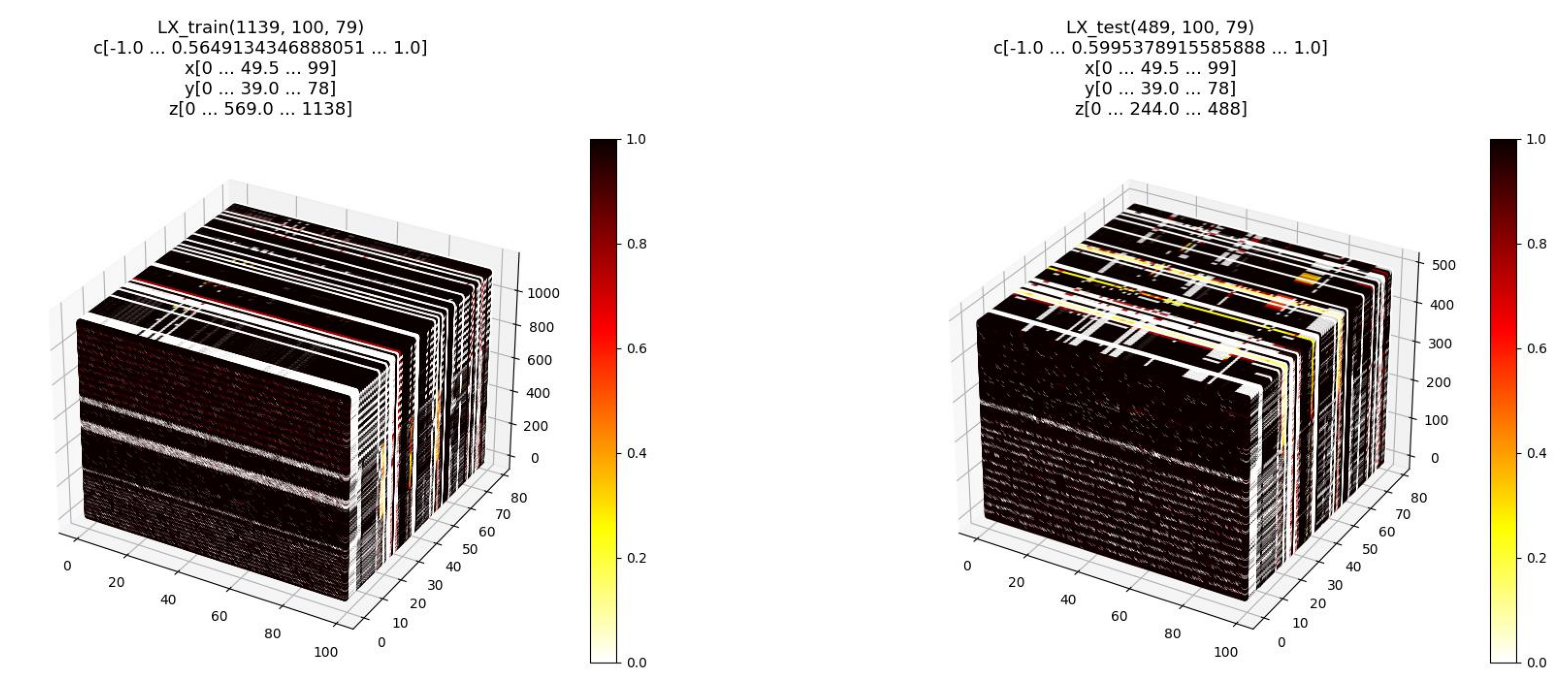

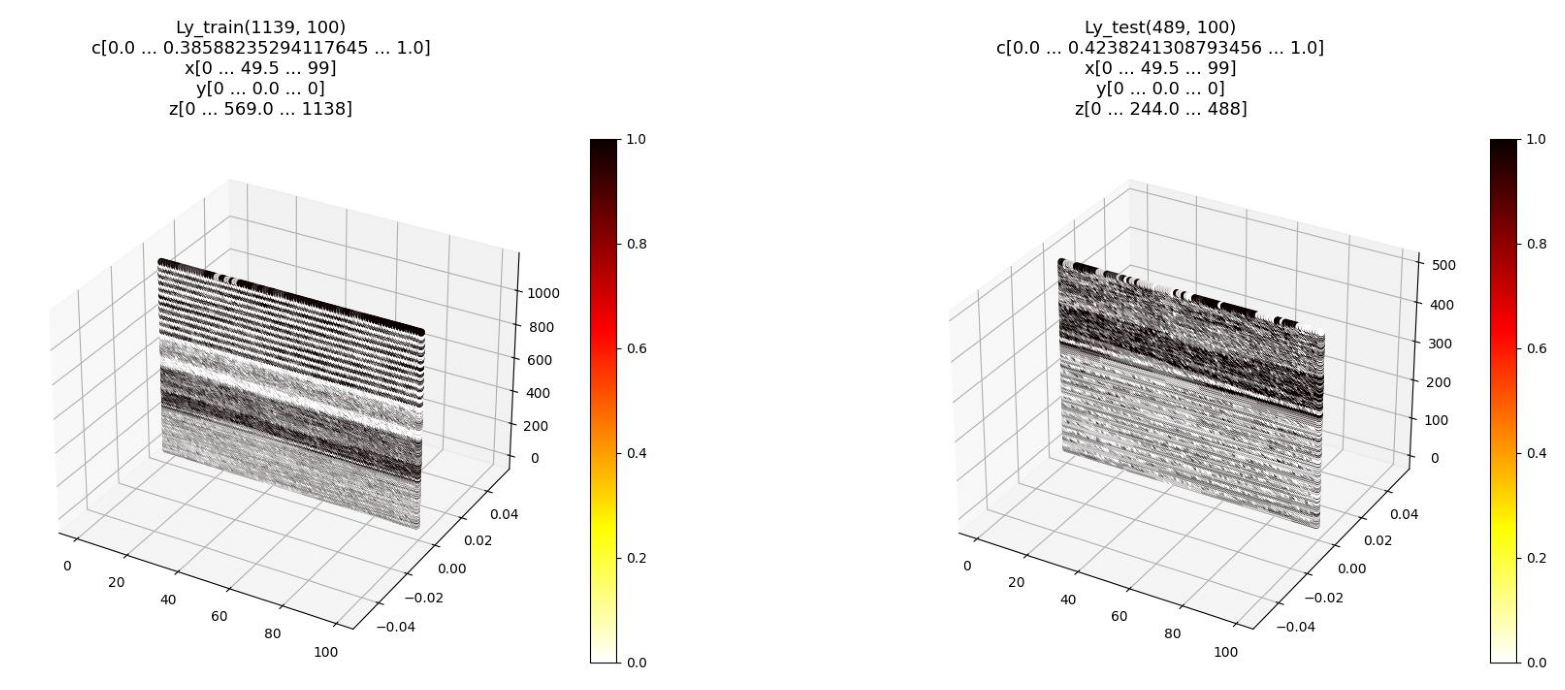

In [14]:
#@title overview featured vs normalized data IMG

show_4d_imgs(['LX_train','LX_test'])
show_4d_imgs(['Ly_train','Ly_test'])

# 4.INTRODUCTION

To create powerful models, especially for solving Seq2Seq learning problems, LSTM is the key layer.
To use LSTM effectively in models, we need to understand how it generates different results with respect to given parameters.

## 4.1.QUICK RECAP OF LSTM

### 4.1.1.Internal Structure

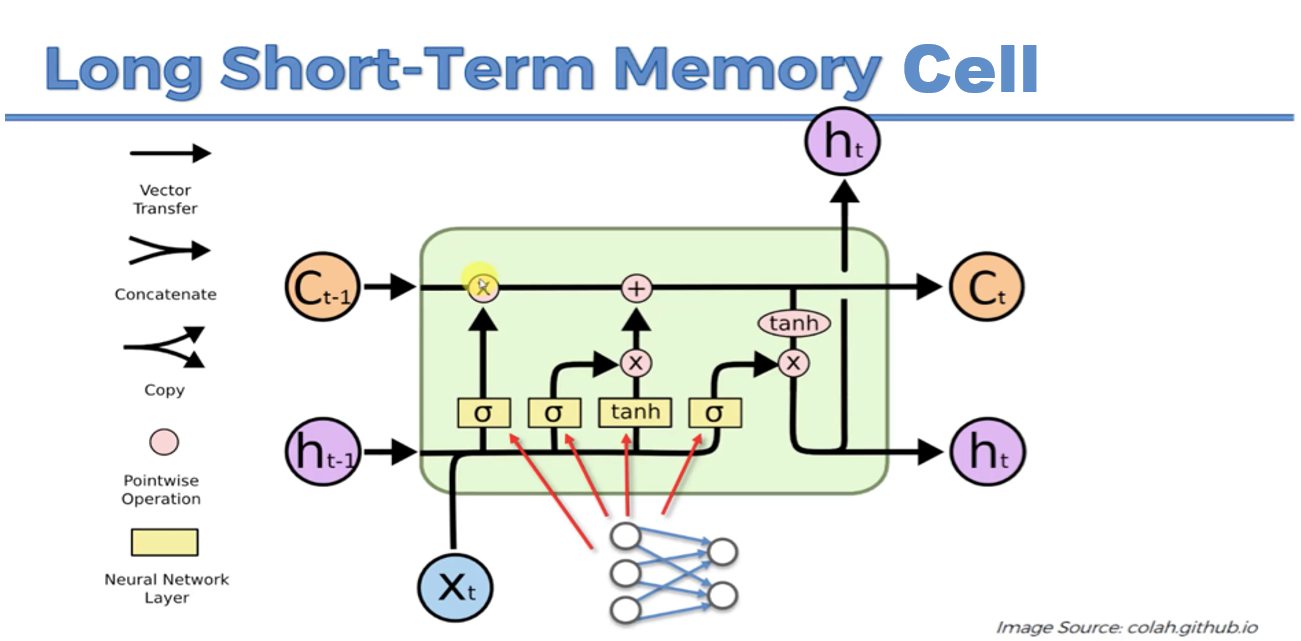

### 4.1.2.Roll-Out Representation of LSTM for each Time Step

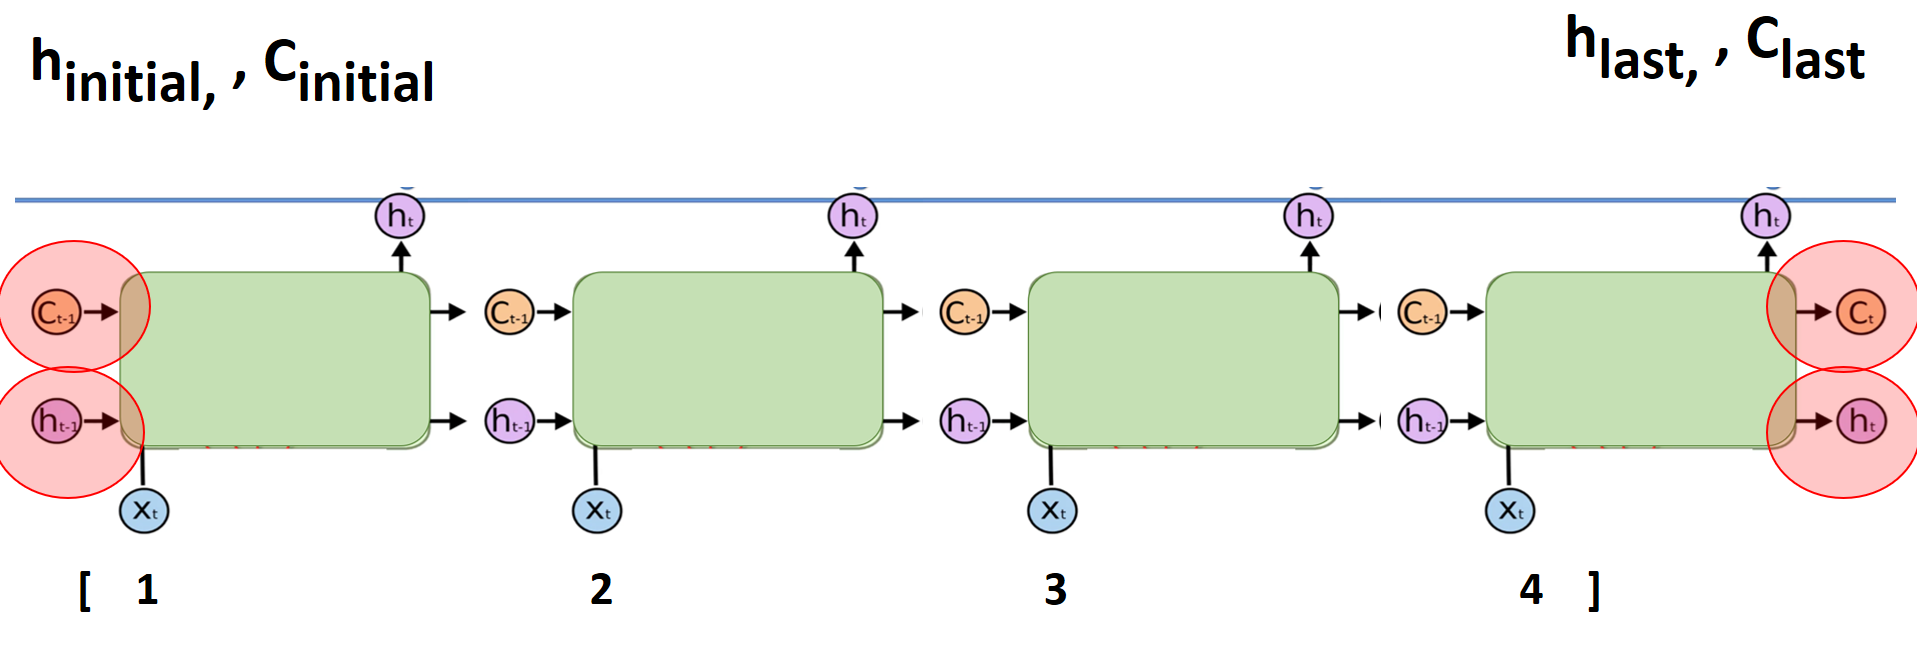

# 5.Train function

In [15]:
#@title train function

def train(model, name='model6'):
  model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
  history = model.fit(LX_train, Ly_train, batch_size=batch_size, epochs=epochs, validation_data=(LX_test, Ly_test))
  show_train_metric(history, name)
  model.save(f"/usr/local/opnsense/scripts/ml/aicheckpoints/{checkpoint}/{name}")
  open(f"/usr/local/opnsense/scripts/ml/aicheckpoints/{checkpoint}/{name}/features.json", "w").write(json.dumps(features))
  common.saving_checkpoint_to_mlflow(f"/usr/local/opnsense/scripts/ml/aicheckpoints/{checkpoint}/{name}")

In [19]:
#@title infer function
def threshold(num):
    return 1 if num > 0.5 else 0

def infer_by_checkpoint(checkpoint, name='model6'):
  model = keras.models.load_model(f"/usr/local/opnsense/scripts/ml/aicheckpoints/{checkpoint}/{name}")
  ##############LX_train
  L_result1=model.predict(LX_train)
  train_predicted = np.vectorize(threshold)(L_result1)
  df = evaluate_checkpoint_metric(checkpoint, train_predicted.ravel(), Ly_train.ravel())
  print("train_predicted", df.to_string())

  ##############LX_test
  L_result2=model.predict(LX_test)
  test_predicted = np.vectorize(threshold)(L_result2)
  df = evaluate_checkpoint_metric(checkpoint, test_predicted.ravel(), Ly_test.ravel())
  print("test_predicted", df.to_string())
  

  IMG['Ly_train_predicted'], IMG['Ly_test_predicted'] = ray.get([
    show_scattered_4d.remote(L_result1, "Ly_train_predicted"),
    show_scattered_4d.remote(L_result2, "Ly_test_predicted"),
  ])
  show_4d_imgs(['LX_train','Ly_train','Ly_train_predicted'])
  show_4d_imgs(['LX_test','Ly_test','Ly_test_predicted'])


___

# 6.LSTM Anomaly model (Primary)

## 6.1.Model layers



In [20]:
def new_model6():
  num_outputs = 10
  # Define input layers
  input_layer = tf.keras.layers.Input(shape=(None, n_features), name="inputs")
  #state_in_h = tf.keras.layers.Input(shape=(cell_size,), name="h")
  #state_in_c = tf.keras.layers.Input(shape=(cell_size,), name="c")
  #seq_in = tf.keras.layers.Input(shape=(), name="seq_in", dtype=tf.int32)

  # Preprocess observation with a hidden layer and send to LSTM cell
  #tf.nn.sigmoid
  dense1 = tf.keras.layers.Dense(hidden_size, activation=None, name="dense1")(input_layer)
  lstm_out, state_h, state_c = tf.keras.layers.LSTM(
      cell_size, return_sequences=True, return_state=True, name="lstm")(
      inputs=dense1,
      #mask=tf.sequence_mask(seq_in),
      #initial_state=[state_in_h, state_in_c]
      )

  # Postprocess LSTM output with another hidden layer and compute values
  logits = tf.keras.layers.Dense(
      num_outputs,
      activation=tf.keras.activations.linear,
      name="logits")(lstm_out)
  values = tf.keras.layers.Dense(
      1, activation="sigmoid", name="values")(lstm_out)

  # Create the RNN model
  model6: Model = Model(
      inputs=input_layer,
      #[
      #  input_layer, #seq_in,
      #  state_in_h,
      #  state_in_c
      #],
      outputs=values
      #[
      #  logits,
      #  values,
      #  state_h,
      #  state_c
      #]
      )
  return model6

model6 = new_model6()
model6.summary()

2023-03-18 16:47:33.932192: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-03-18 16:47:33.932948: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13348 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-03-18 16:47:33.933689: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capability: 8.6
2023-03-18 16:47:33.934431: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 13348 MB memory:  -> device: 3, name: NVIDIA A16, pci bus id: 0000:42:00.0, compute capability: 8.6


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 79)]        0         
                                                                 
 dense1 (Dense)              (None, None, 230)         18400     
                                                                 
 lstm (LSTM)                 [(None, None, 320),       705280    
                              (None, 320),                       
                              (None, 320)]                       
                                                                 
 values (Dense)              (None, None, 1)           321       
                                                                 
Total params: 724,001
Trainable params: 724,001
Non-trainable params: 0
_________________________________________________________________


## 6.2.Train



Epoch 1/110


2023-03-18 16:47:38.829038: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-18 16:47:39.735820: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204


36/36 [==============================] - 5s 32ms/step - loss: 0.3486 - accuracy: 0.8453 - val_loss: 0.2065 - val_accuracy: 0.9294
Epoch 2/110
36/36 [==============================] - 1s 18ms/step - loss: 0.1478 - accuracy: 0.9575 - val_loss: 0.0664 - val_accuracy: 0.9922
Epoch 3/110
36/36 [==============================] - 1s 18ms/step - loss: 0.0711 - accuracy: 0.9872 - val_loss: 0.0393 - val_accuracy: 0.9906
Epoch 4/110
36/36 [==============================] - 1s 18ms/step - loss: 0.0485 - accuracy: 0.9884 - val_loss: 0.0278 - val_accuracy: 0.9937
Epoch 5/110
36/36 [==============================] - 1s 18ms/step - loss: 0.0385 - accuracy: 0.9904 - val_loss: 0.0246 - val_accuracy: 0.9918
Epoch 6/110
36/36 [==============================] - 1s 19ms/step - loss: 0.0352 - accuracy: 0.9905 - val_loss: 0.0176 - val_accuracy: 0.9948
Epoch 7/110
36/36 [==============================] - 1s 18ms/step - loss: 0.0295 - accuracy: 0.9918 - val_loss: 0.0155 - val_accuracy: 0.9955
Epoch 8/110
36/36 

2023-03-18 16:48:53.610504: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/usr/local/lib/python3.7/dist-packages/mlflow/keras.py:406: UserWarning: The pyfunc inference behavior of Keras models logged with signatures differs from the behavior of Keras models logged without signatures. Specifically, when a signature is present, passing a Pandas DataFrame as input to the pyfunc `predict()` API produces an `ndarray` (for single-output models) or a dictionary of `str -> ndarray`: (for multi-output models). In contrast, when a signature is *not* present, `predict()` produces a Pandas DataFrame output in response to a Pandas DataFrame input.
  "The pyfunc inference behavior of Keras models logged "
/usr/local/lib/python3.7/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'Ano

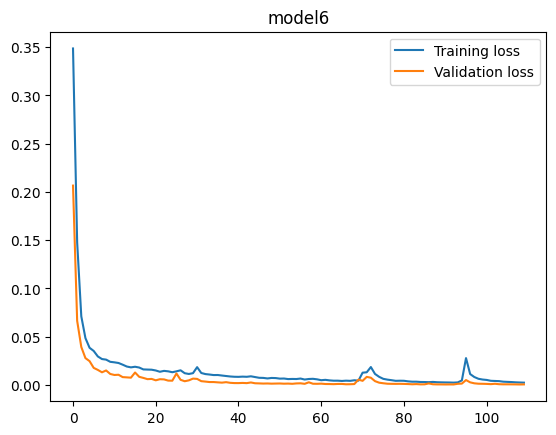

In [21]:
train(model6)

## 6.3.Infer



In [22]:
infer_by_checkpoint(checkpoint)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# 7.MODEL WEIGHTS SUMMARY

In [ ]:
weights6 = show_weights(model6, 'model6')
show_4d_imgs(weights6)